# Application Serving Pipeline

This notebook demonstrate how to serve standard ML/DL models using **MLRun Serving**.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](./01-mlrun-basics.html).


MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source "serverless" framework that's focused on data, I/O, and compute-intensive workloads.


MLRun serving supports advanced real-time data processing and model serving pipelines.<br>
For more details and examples, see the {ref}`MLRun serving pipelines <serving>` documentation.

Tutorial steps:
- [**Create, test and build advanced model Serving Graph**](#serving-function)
- [**Deploy the serving Function**](#deploy-serving)

In [7]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="huggingface-demo", context="./"
)

> 2023-02-08 11:47:20,325 [info] loaded project huggingface-demo from MLRun DB


<a id="serving-function"></a>
## Create and test the Serving Function

The serving function kind is using [Nuclio](https://nuclio.io/): a high-performance serverless event 
and data processing open-source platform. With just a few lines of code we can take our model, **expose** it with an **http endpoint** and deploy it on 
**high-performance** infrastructure that can easily scale up to serve on a **production environment** with hundreds of 
thousands of requests per second. To read more about serving functions in MLRun and some cool advanced features like model routers, error handling and more, please refer to our [documentation](https://docs.mlrun.org/en/latest/serving/serving-graph.html).


In [8]:
serving_function = mlrun.code_to_function(
    filename="src/onnx_model_server.py",
    name="hugging-face-serving",
    kind="serving", 
    image="davesh0812/mlrun:mlrun-huggingface-demo-1",
)

In [9]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

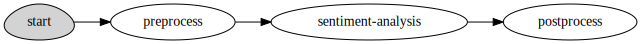

In [10]:
from mlrun.feature_store.steps import DateExtractor
model_server_class = 'ONNXModelServer'
model_uri = project.get_artifact('optimized_model').uri

# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to(class_name=model_server_class, name="sentiment-analysis", model_path=model_uri)\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [11]:
project.set_function(serving_function,  with_repo=True)
project.save()

In [12]:
# create a mock server (in memory simulator for the graph for testing)
server = serving_function.to_mock_server()

body = "i love flying"

# simulate a user request and print the results
response = server.test(path='/predict', body=body)
print(response)

> 2023-02-08 11:47:39,014 [info] downloading v3io:///projects/huggingface-demo/artifacts/trainer-train/0/tokenizer.zip to local temp file


Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'


> 2023-02-08 11:47:39,739 [info] model sentiment-analysis was loaded
['The sentiment is POSITIVE', 'The prediction score is 0.16869324445724487']


<a id="deploy-serving"></a>
## Deploy the serving Function


In [13]:
# Deploy it:
deployment = project.deploy_function(serving_function)

> 2023-02-08 11:47:56,473 [info] Starting remote function deploy
2023-02-08 11:47:56  (info) Deploying function
2023-02-08 11:47:56  (info) Building
2023-02-08 11:47:56  (info) Staging files and preparing base images
2023-02-08 11:47:56  (info) Building processor image
2023-02-08 11:50:36  (info) Build complete
2023-02-08 11:50:46  (info) Function deploy complete
> 2023-02-08 11:50:46,961 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-huggingface-demo-hugging-face-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['huggingface-demo-hugging-face-serving-huggingface-demo.default-tenant.app.cto-office.iguazio-cd1.com/']}


In [14]:
response = deployment.function.invoke(path='/predict', body=body)
print(response)

> 2023-02-08 11:50:47,003 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-huggingface-demo-hugging-face-serving.default-tenant.svc.cluster.local:8080/predict'}
['The sentiment is POSITIVE', 'The prediction score is 0.19319972395896912']


## Gradio front-end

Gradio is a friendly web interface that we demonstrate here how to use easily for submitting predictions to our real-time pipeline and to get the results as well!

For more information, please see [gradio page](https://gradio.app/)

In [15]:
serving_url = deployment.outputs['endpoint']

In [16]:
import gradio as gr
import requests

In [17]:
def sentiment(text):
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()


with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="Text to analyze", placeholder="Please insert text")]
    output = [gr.Textbox(label="Sentiment analysis result"), gr.Textbox(label="Sentiment analysis score")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a68eddb4-a787-4827.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
